# Click-base Lambdas Experiments

## Import necessary modules

In [14]:
import os
os.system("export LC_ALL=en_US.UTF-8")
os.system("export LANG=en_US.UTF-8")

%matplotlib inline

import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

from matplotlib.ticker import MultipleLocator

# Load the click models for the queries of interest.
with open('./data/model_query_lambdas_10reps_collection.pkl') as ifile:
    MQD = pickle.load(ifile)

# For reproducibility -- re-seed the click models' RNGs.
for click_model_type in MQD:
    for query in MQD[click_model_type]:
        MQD[click_model_type][query]['model'].seed = 42

# Queries Examination

## Available Click Models

In [2]:
MQD.keys()

['DCM', 'CM', 'DBN', 'CCM', 'PBM', 'UBM']

## Available Queries

In [3]:
MQD['CCM'].keys()

['2548',
 '77932',
 '1153',
 '42696',
 '49111',
 '297115',
 '39492',
 '59560',
 '28658',
 '486195']

## Model-Query Attractiveness (Relevance) Scores

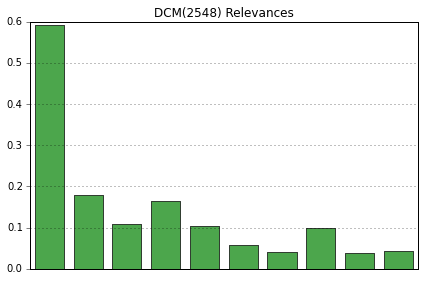

In [4]:
from ipywidgets import interactive, Dropdown, VBox, HBox
from IPython.display import display

def show_relevances_widget():
    def show_relevances(click_model_type, query):
        relevances = MQD[click_model_type][query]['relevances']

        plt.bar(np.arange(len(relevances)), relevances,
               0.75, alpha=0.7, color='green', align='center')

        plt.title('%s(%s) Relevances' % (click_model_type, query))
        plt.grid(axis='y', which='major')
        plt.tick_params(axis='both', which='major', left='on', direction='out',
                       top='off', right='off', bottom='off', labelleft='on',
                       labeltop='off', labelright='off', labelbottom='off')
        plt.xlim([-0.5, len(relevances) - 0.5])

        plt.tight_layout()
        plt.show()

    cmdd = Dropdown(options=MQD.keys(), description='Click Model:')
    qdd = Dropdown(options=MQD['CCM'].keys(), description='Query:')
    
    controls = HBox([cmdd, qdd])
    backend = interactive(show_relevances, click_model_type=cmdd, query=qdd)

    controls.on_displayed(lambda _: show_relevances(cmdd.value, qdd.value))

    display(controls)

show_relevances_widget()

# Documents Attractiveness under CM

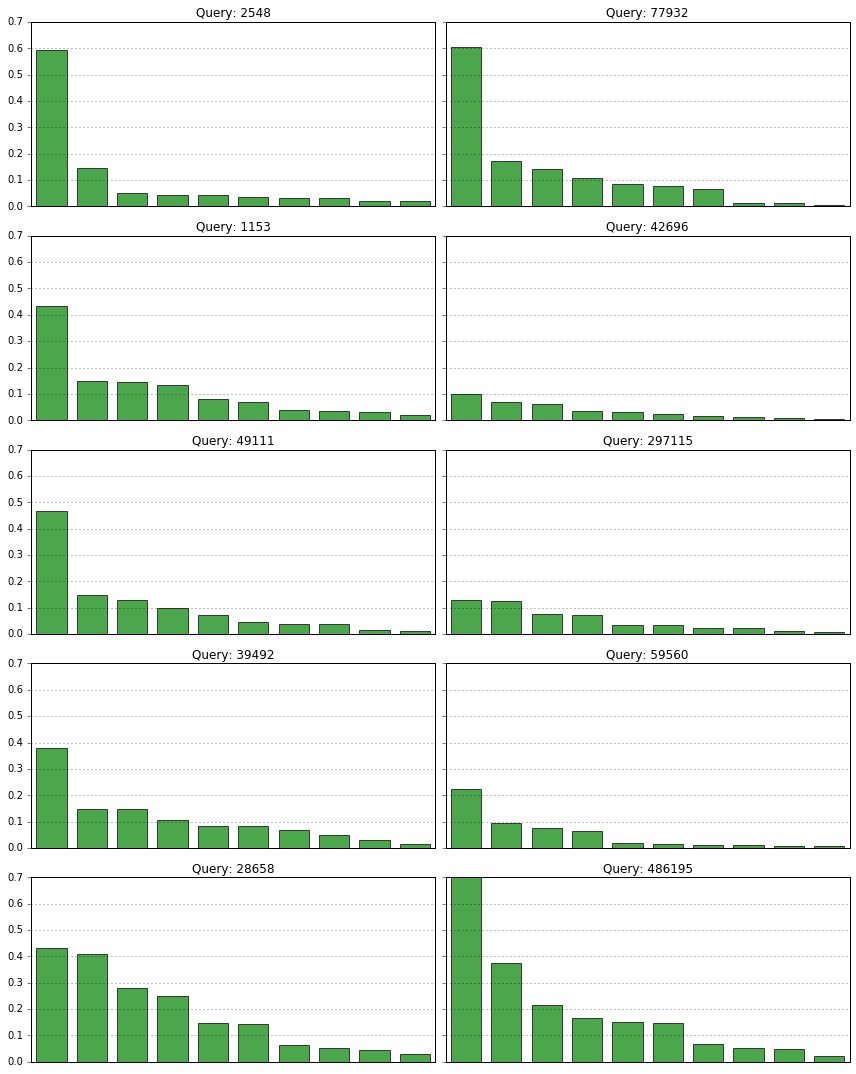

In [5]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['CM'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['CM'][query]['ideal_ranking']
    relevances = MQD['CM'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Documents Attractiveness under PBM

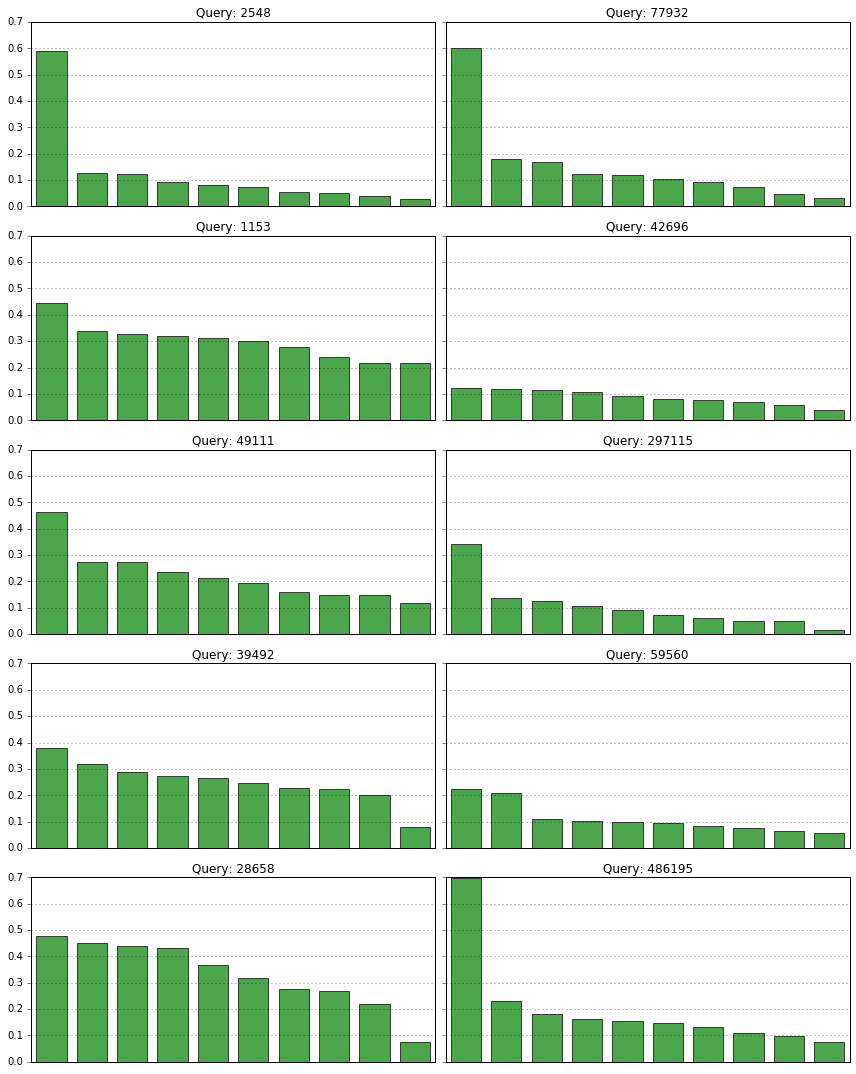

In [6]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['PBM'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['PBM'][query]['ideal_ranking']
    relevances = MQD['PBM'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Documents Attractiveness under DCM

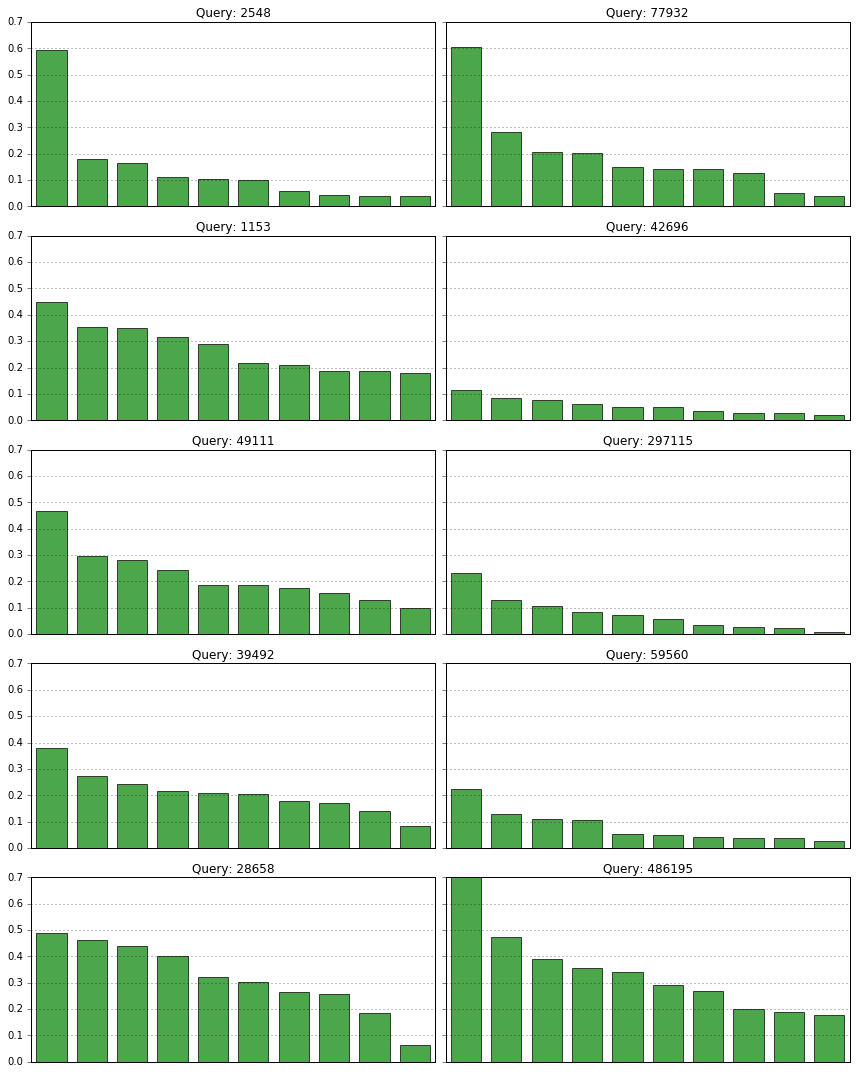

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['DCM'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['DCM'][query]['ideal_ranking']
    relevances = MQD['DCM'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Documents Attractiveness under CCM

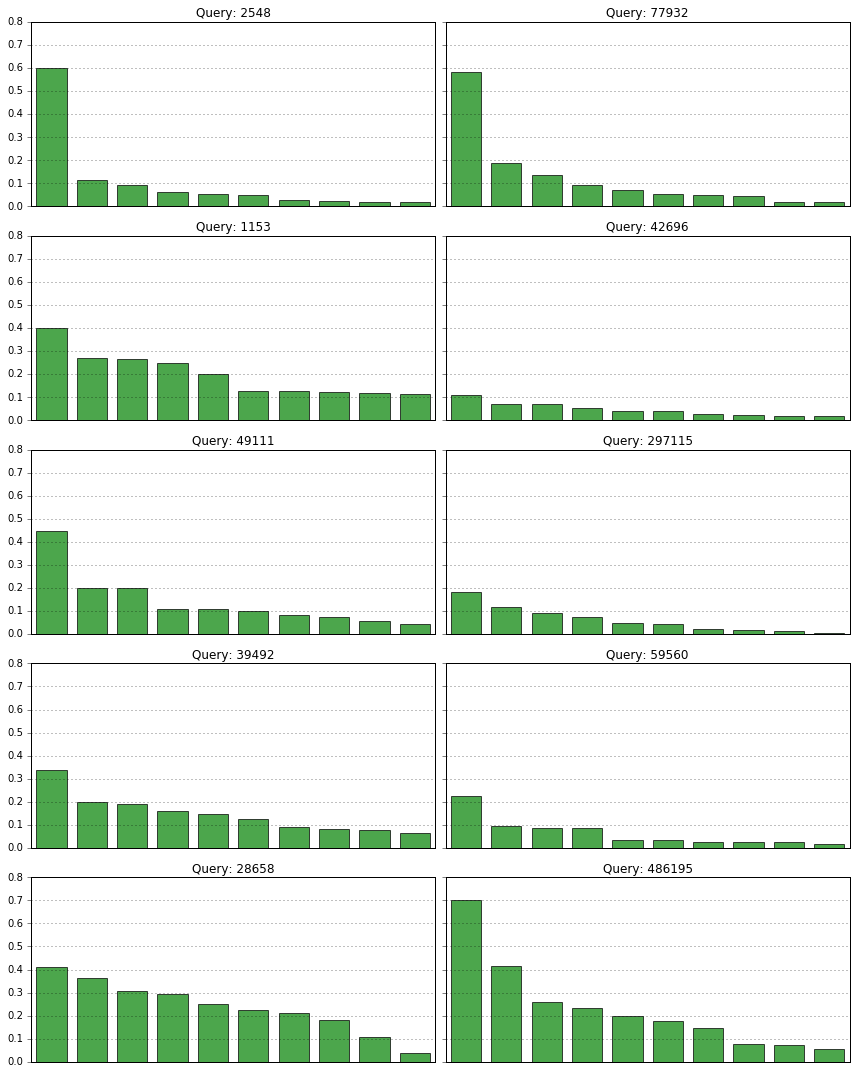

In [8]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['CCM'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['CCM'][query]['ideal_ranking']
    relevances = MQD['CCM'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Documents Attractiveness under DBN

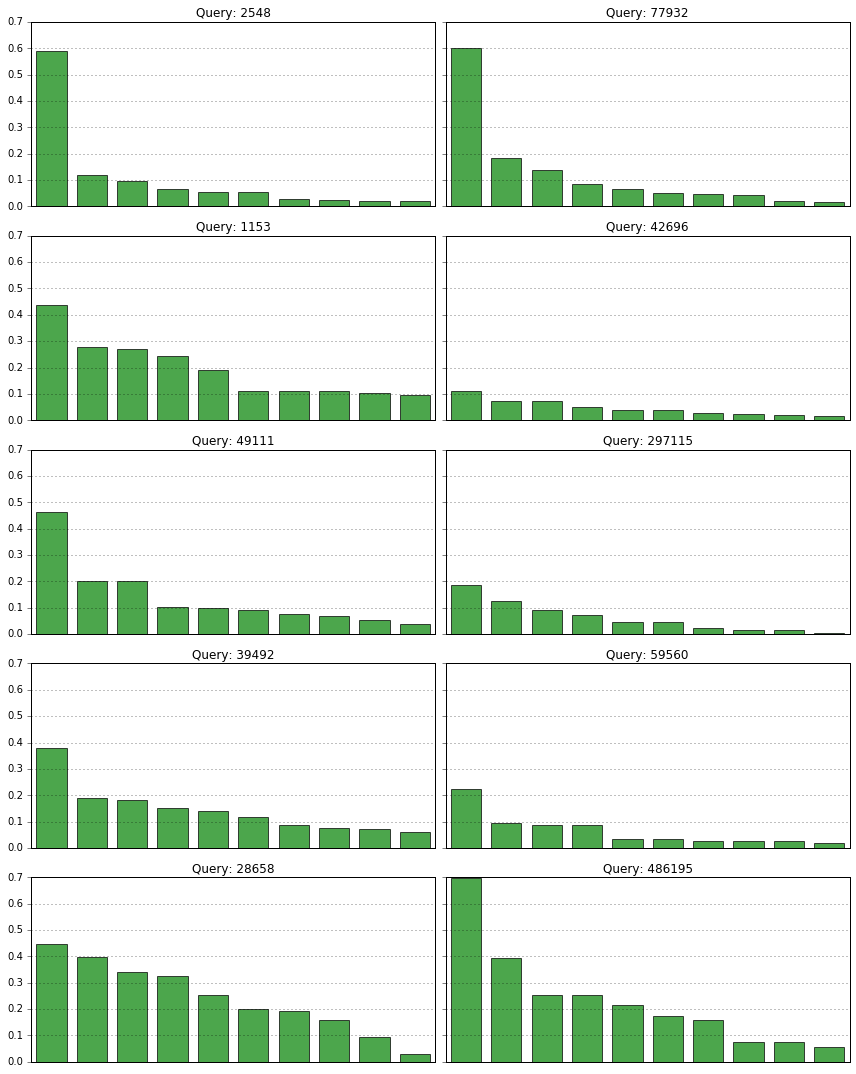

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['DBN'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['DBN'][query]['ideal_ranking']
    relevances = MQD['DBN'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Documents Attractiveness under UBM

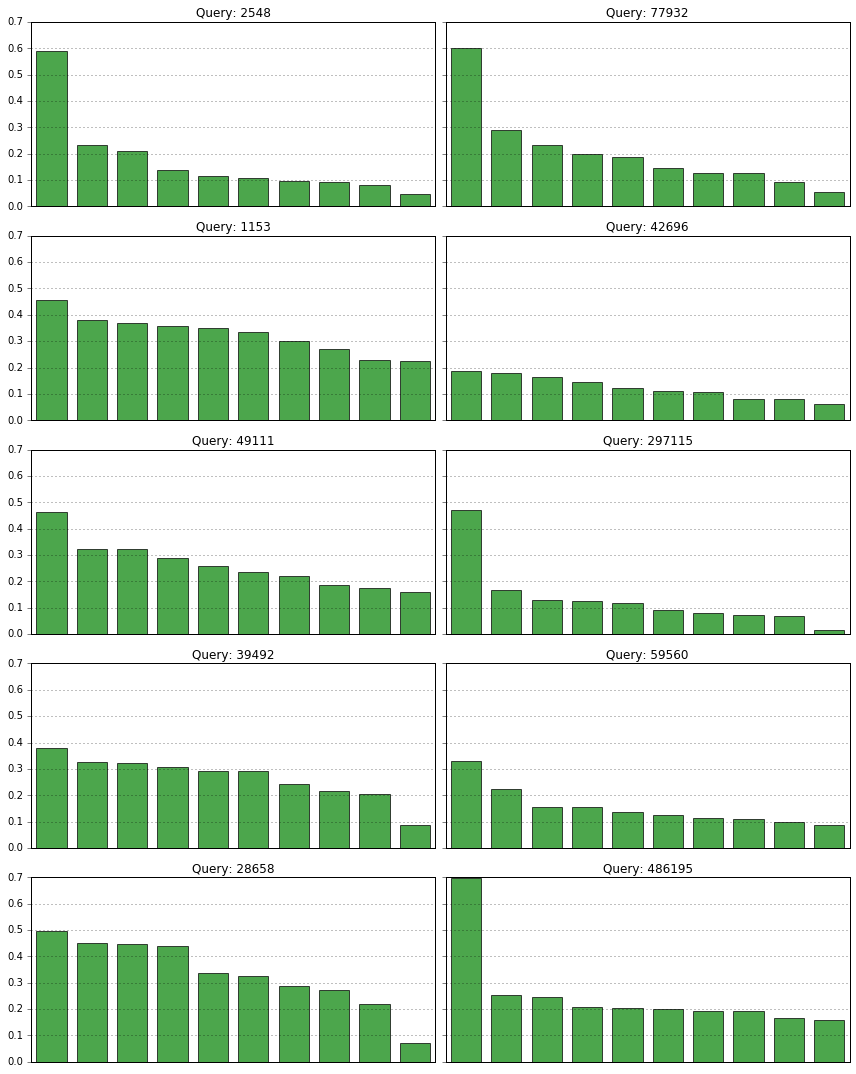

In [10]:
fig, axes = plt.subplots(5, 2, figsize=(12, 15), sharex=True, sharey=True)

for i, query in enumerate(MQD['UBM'].keys()):
    ax = axes[i / 2, i % 2]
    
    ideal_ranking = MQD['UBM'][query]['ideal_ranking']
    relevances = MQD['UBM'][query]['relevances']
    
    ax.bar(np.arange(len(relevances)), relevances[ideal_ranking],
           0.75, alpha=0.7, color='green', align='center')
    
    ax.set_title('Query: %s' % query)
    ax.grid(axis='y', which='major')
    ax.tick_params(axis='both', which='major', left='on', direction='out',
                   top='off', right='off', bottom='off', labelleft='on',
                   labeltop='off', labelright='off', labelbottom='off')
    ax.set_xlim([-0.5, len(relevances) - 0.5])

plt.tight_layout()
plt.show(fig)

# Simulate Clicks and Estimate Lambdas

## Method for estimating lambdas from uniformly shuffled impressions

In [11]:
def compute_lambdas(click_model_type, query, n_impressions, seed=None):
    random_state = np.random.RandomState(seed)

    relevances = MQD[click_model_type][query]['relevances']
    click_model = MQD[click_model_type][query]['model']

    n_documents = len(relevances)

    lambdas = np.zeros((n_documents, n_documents), dtype='int32')
    counts = np.zeros((n_documents, n_documents), dtype='int32')

    ranking = np.arange(n_documents, dtype='int32')
    identity = np.arange(n_documents, dtype='int32')

    for n in range(n_impressions):
        # SHUFFLING THE RANKING
        random_state.shuffle(ranking)
        clicks = click_model.get_clicks(ranking, identity)

        if clicks.any():
            last_click_rank = np.where(clicks)[0][-1]
            for i in range(last_click_rank):
                d_i = ranking[i]
                for j in range(i + 1, last_click_rank + 1):
                    if clicks[i] < clicks[j]:
                        d_j = ranking[j]
                        lambdas[d_i, d_j] -= 1
                        lambdas[d_j, d_i] += 1
                        counts[d_j, d_i] += 1

    with np.errstate(invalid='ignore'):
        lambdas = np.nan_to_num(lambdas.astype('float64') / (counts + counts.T))
        
    return lambdas, counts

## Thompson Sampling method for estimation of lambdas

In [12]:
def compute_lambdas_thompson(click_model_type, query, n_impressions, seed=None):
    random_state = np.random.RandomState(seed)

    relevances = MQD[click_model_type][query]['relevances']
    click_model = MQD[click_model_type][query]['model']

    n_documents = len(relevances)
    
    alphas = np.ones((n_documents, n_documents), dtype='float64')
    betas = np.ones((n_documents, n_documents), dtype='float64')

    identity = np.arange(n_documents, dtype='int32')

    ranking_scores = np.empty(n_documents, dtype=[('c', 'float64'), ('b', 'float64')])
    copeland_scores = ranking_scores['c']
    borda_scores = ranking_scores['b']

    for n in range(n_impressions):
        # Prepare ranking scores...
        ranking_scores.fill(0.)
        
        for i in range(n_documents - 1):
            for j in range(i + 1, n_documents):
                d = (random_state.beta(alphas[i, j], betas[i, j]) -
                     random_state.beta(alphas[j, i], betas[j, i]))
                
                s = np.sign(d)
                
                copeland_scores[i] += s
                copeland_scores[j] -= s
                
                borda_scores[i] += d
                borda_scores[j] -= d
                
        ranking = np.argsort(ranking_scores)[::-1]

        clicks = click_model.get_clicks(ranking, identity)

        if clicks.any():
            last_click_rank = np.where(clicks)[0][-1]
            for i in range(last_click_rank):
                d_i = ranking[i]
                for j in range(i + 1, last_click_rank + 1):
                    if clicks[i] < clicks[j]:
                        d_j = ranking[j]
                        betas[d_i, d_j] += 1
                        alphas[d_j, d_i] += 1
    
    lcounts = alphas + betas
    lambdas = alphas / lcounts
        
    return lambdas, lcounts

# Visualize Lambdas vs Deltas for a Click Model

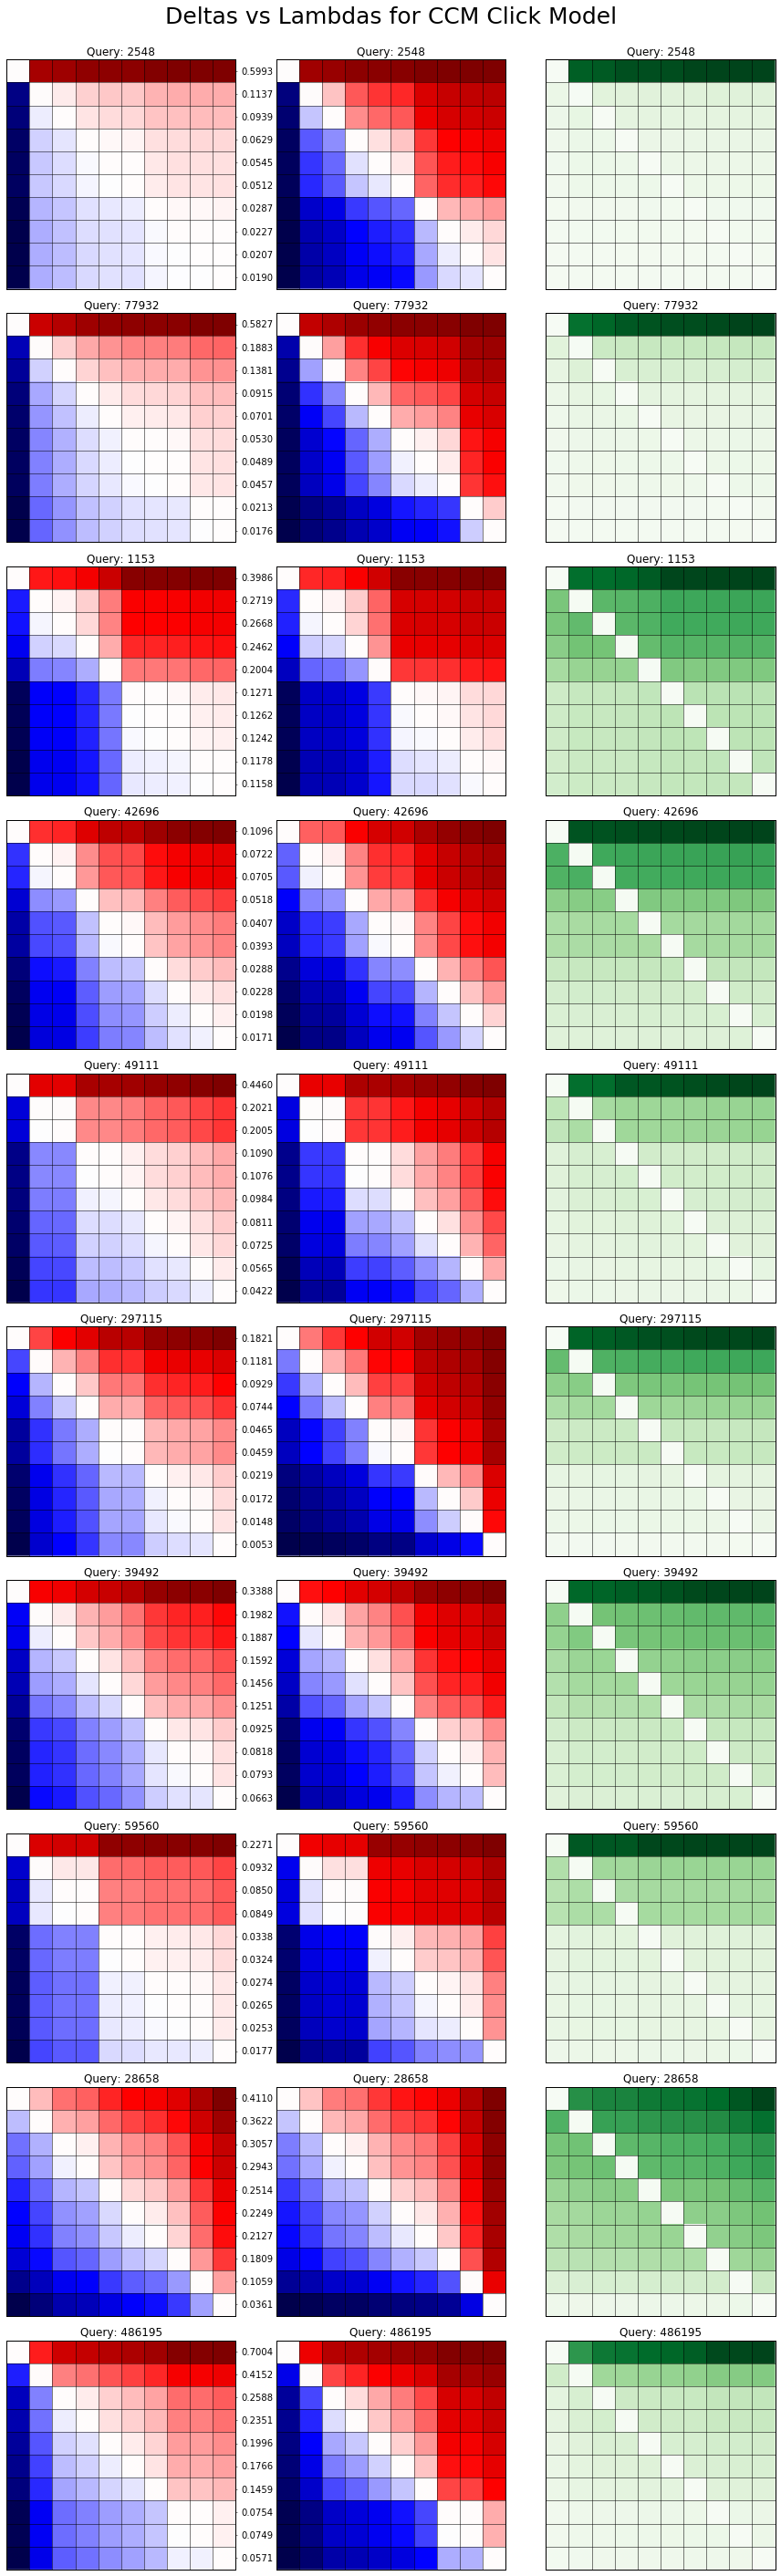

In [13]:
from ipywidgets import interact, Dropdown

# If precalculated lambdas are not used this is just a sanity
# check for lambdas computed from this number of impressions.
n_impressions = 100000

def show_click_model_lambdas(click_model_type):
    fig, axes = plt.subplots(10, 3, figsize=(12, 40))

    fig.suptitle('Deltas vs Lambdas for %s Click Model' % click_model_type,
                 fontsize=25)

    # Compute deltas (relevance differences) and plot them
    # into the 1st column of the heatmap plot.
    for i, query in enumerate(MQD[click_model_type].keys()):
        ax = axes[i, 0]

        ax.tick_params(axis='both', which='major', left='off',  top='off',
                       right='off', bottom='off', labelleft='off',  labeltop='off',
                       labelright='off', labelbottom='off')

        ax.tick_params(axis='both', which='minor', direction='out', left='off',
                       top='off', right='on', bottom='off', labelleft='off',
                       labeltop='off', labelright='on', labelbottom='off')

        ideal_ranking = MQD[click_model_type][query]['ideal_ranking']
        relevances = MQD[click_model_type][query]['relevances'][ideal_ranking]

        ax.imshow(relevances[:, None] - relevances[None, :], interpolation='none',
                  cmap=plt.get_cmap('seismic'), extent=[0, 10, 0, 10])

        ax.set_title('Query: %s' % query)
        ax.xaxis.set_major_locator(MultipleLocator(1.0))
        ax.yaxis.set_major_locator(MultipleLocator(1.0))
        ax.set_yticks(np.arange(len(relevances)) + 0.5, minor=True)
        ax.set_yticklabels(map(lambda s: '%.4f' % s, relevances[::-1]), minor=True)
        ax.grid(True, ls='-')

    # Compute lambdas and plot them into the 2nd column
    # of the heatmap plot.
    for i, query in enumerate(MQD[click_model_type].keys()):
        ax = axes[i, 1]

        ax.tick_params(axis='both', which='both', left='off',  top='off',
                       right='off', bottom='off', labelleft='off',  labeltop='off',
                       labelright='off', labelbottom='off')

        ideal_ranking = MQD[click_model_type][query]['ideal_ranking']

        # If `MQD` was loaded in the previous code cell, it contains
        # pre-calculated lambdas ...
        if 'stats' in MQD[click_model_type][query]:
            # Taking one from the set of 10 lambas in each (model, query)-pair.
            lambdas = MQD[click_model_type][query]['stats'][1000000]['lambdas'][0]
            lcounts = MQD[click_model_type][query]['stats'][1000000]['lcounts'][0]
        else:
            # ... otherwise lambdas will be calculated.
            lambdas, lcounts = compute_lambdas(click_model_type, query, n_impressions)
            # lambdas, lcounts = compute_lambdas_thompson(click_model_type, query, n_impressions)

        # ... and reorder them according to the ideal ranking.
        lambdas = lambdas[ideal_ranking, :]
        lambdas = lambdas[:, ideal_ranking]

        ax.imshow(lambdas, interpolation='none', cmap=plt.get_cmap('seismic'),
                  extent=[0, 10, 0, 10])

        ax.set_title('Query: %s' % query)
        ax.xaxis.set_major_locator(MultipleLocator(1.0))
        ax.yaxis.set_major_locator(MultipleLocator(1.0))
        ax.grid(True, ls='-')

        # ===========================================================================
        # Same plot for the heatmap showing the counts of impressions
        # which were used to compute individual lambda_ij's.
        # ===========================================================================

        ax = axes[i, 2]

        ax.tick_params(axis='both', which='both', left='off',  top='off',
                       right='off', bottom='off', labelleft='off',  labeltop='off',
                       labelright='off', labelbottom='off')

        # Reorder the lambda sample counts according to the ideal ranking.
        lcounts = lcounts[ideal_ranking, :]
        lcounts = lcounts[:, ideal_ranking]

        ax.imshow(lcounts, interpolation='none', cmap=plt.get_cmap('Greens'),
                  extent=[0, 10, 0, 10])

        ax.set_title('Query: %s' % query)
        ax.xaxis.set_major_locator(MultipleLocator(1.0))
        ax.yaxis.set_major_locator(MultipleLocator(1.0))
        ax.grid(True, ls='-')

    plt.tight_layout()
    plt.subplots_adjust(top=0.96) # Because of suptitle.
    plt.show(fig)

_ = interact(show_click_model_lambdas, click_model_type=Dropdown(options=MQD.keys(), description='Click Model:'))


# Probably Smallest Gap for $\lambda_{ij} \leftrightarrow \Delta_{ij}$

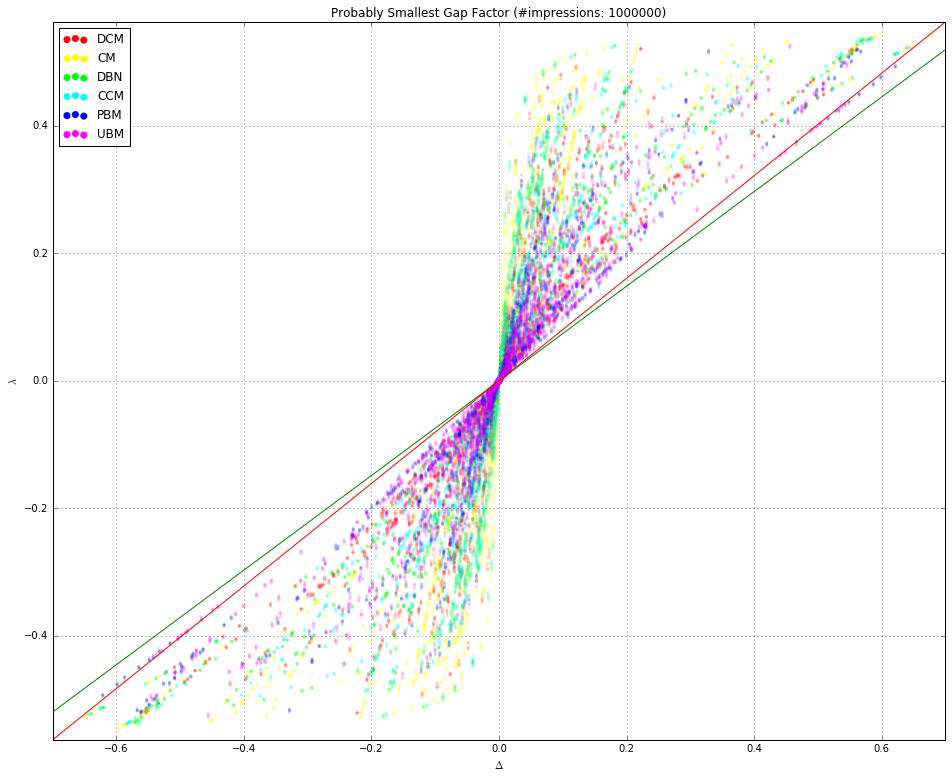

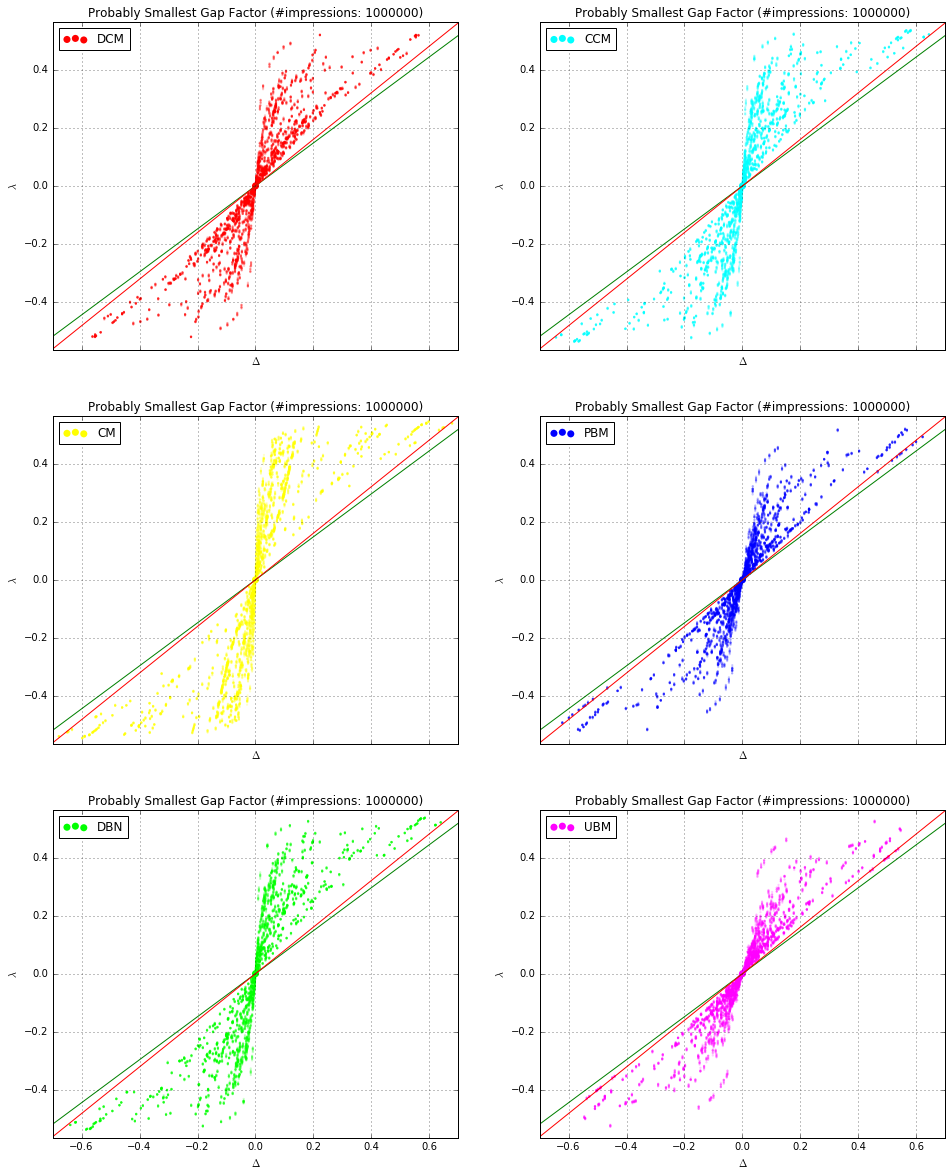

In [14]:
# Fished numbers :)
g1 = 0.741911843196 # 0.22796567480582483 # Green Line :- P(lambda < delta * g1) < 0.0033
r2 = 0.804044404376 # 0.79990317724734594 # Red Line :- P(lambda < delta * g1) < 0.01

fig, axes = plt.subplots(1, 1, figsize=(16, 16), sharex=True)
halfNumCM = len(MQD)/2
pcm_fig, pcm_axes = plt.subplots(halfNumCM, 2, figsize=(16, 20), sharex=True)

for ind, n_impressions in list(enumerate(sorted(MQD[click_model_type][query]['stats'].keys())[-1:])):
    ax = axes #[ind % 5, ind / 5]
    for jnd, click_model_type in enumerate(MQD):
        pcm_ax = pcm_axes[jnd % halfNumCM, jnd / halfNumCM]
        HSV = [jnd*1./len(MQD),1,1]
        RGB = np.mat(hsv_to_rgb(HSV)).A
        ax.scatter(0,0,s=50,c=RGB,edgecolor='none',label=click_model_type)
        pcm_ax.scatter(0,0,s=50,c=RGB,edgecolor='none',label=click_model_type)
        for knd, query in enumerate(MQD[click_model_type]):
            relevances = MQD[click_model_type][query]['relevances']
            deltas = relevances[:, None] - relevances[None, :]
            lambdas = MQD[click_model_type][query]['stats'][n_impressions]['lambdas']

            y = lambdas.ravel()
            x = np.tile(deltas.ravel(), (lambdas.shape[0],))
            
#             nts_x_mask = (np.abs(x) > 1e-3)
#             x = x[nts_x_mask]
#             y = y[nts_x_mask]
            
            ax.scatter(x, y, s=10, c=np.tile(RGB,(x.shape[0],1)),edgecolor='none', alpha=0.07)
            pcm_ax.scatter(x, y, s=5, c=np.tile(RGB,(x.shape[0],1)),edgecolor='none', alpha=0.2)
        x_lim = 0.7
        pcm_ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-')
        pcm_ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-')
        pcm_ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
        pcm_ax.set_title('Probably Smallest Gap Factor (#impressions: %d)' % n_impressions)
        pcm_ax.set_ylabel(r'$\lambda$')
        pcm_ax.set_xlabel(r'$\Delta$')
        pcm_ax.set_aspect('equal')
        pcm_ax.grid(True, axis='both', which='both')
        pcm_ax.legend(loc='upper left')
    ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-')
    ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-')
    ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
    ax.set_title('Probably Smallest Gap Factor (#impressions: %d)' % n_impressions)
    ax.set_ylabel(r'$\lambda$')
    ax.set_xlabel(r'$\Delta$')
    ax.set_aspect('equal')
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.grid(True, axis='both', which='both')
    ax.legend(loc='upper left')
plt.show(fig)

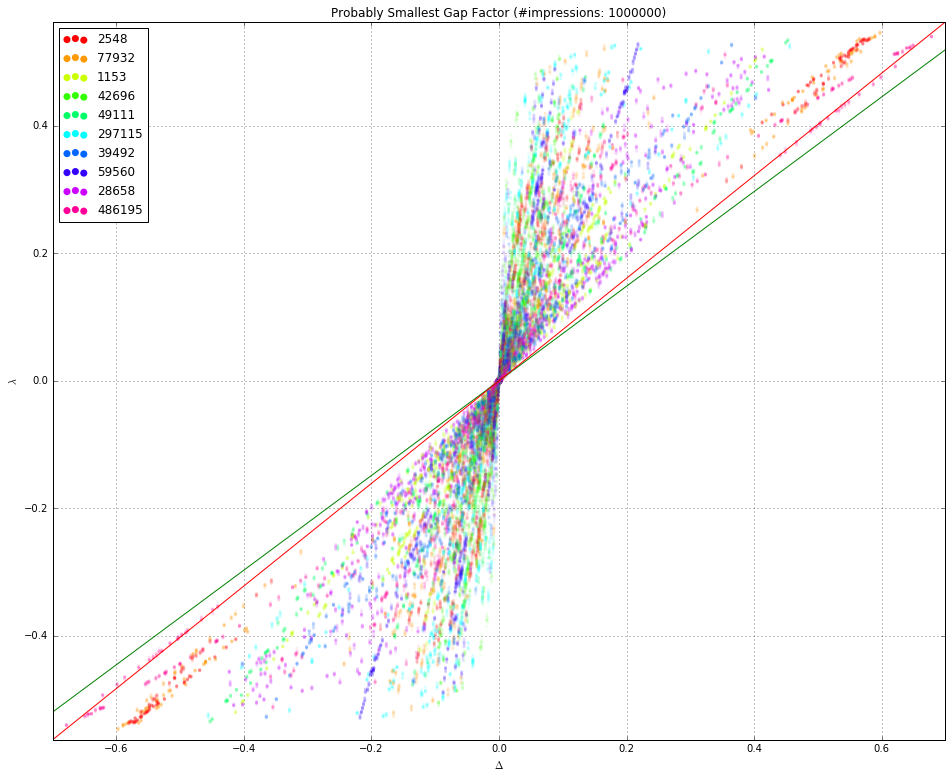

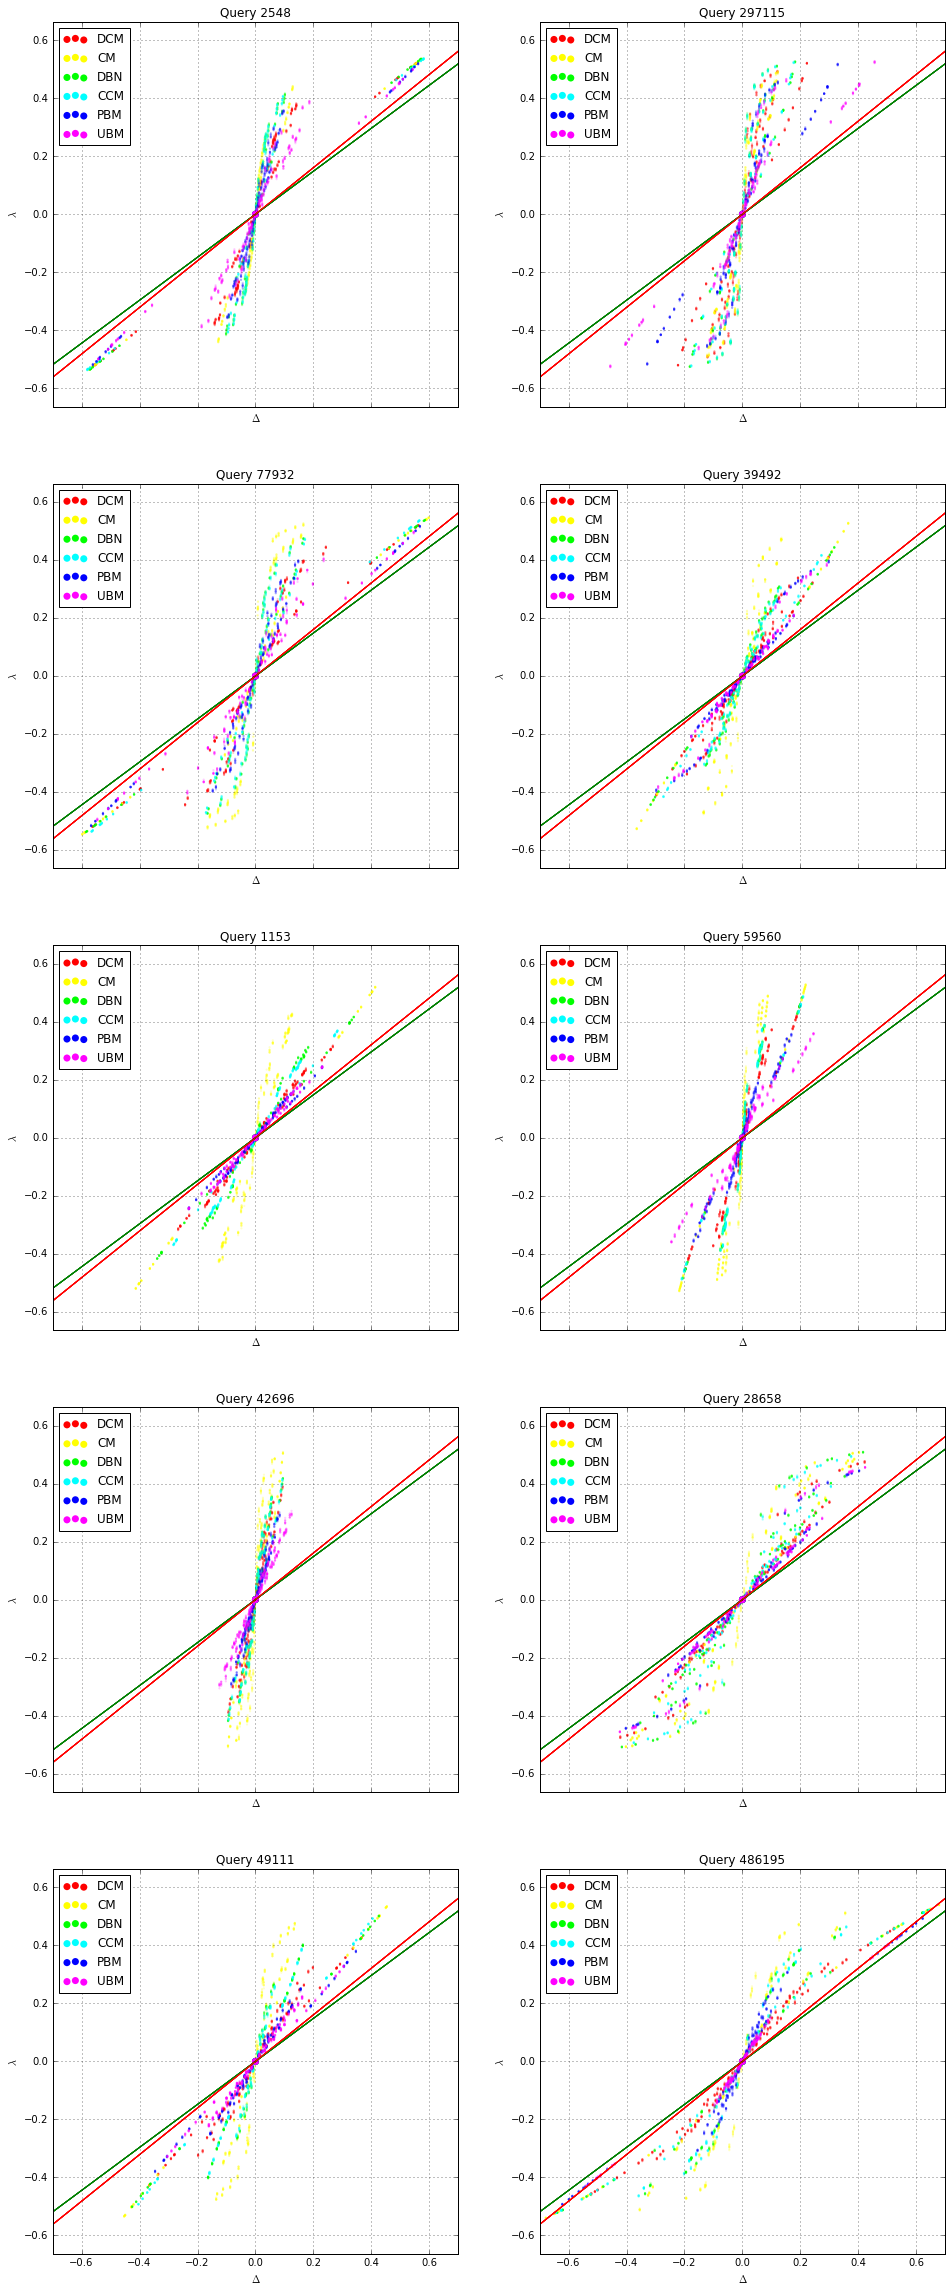

In [65]:
# Fished numbers :)
g1 = 0.741911843196 # 0.22796567480582483 # Green Line :- P(lambda < delta * g1) < 0.0033
r2 = 0.804044404376 # 0.79990317724734594 # Red Line :- P(lambda < delta * g1) < 0.01

fig, axes = plt.subplots(1, 1, figsize=(16, 16), sharex=True)
halfNumQ = len(MQD[MQD.keys()[0]]) / 2
pq_fig, pq_axes = plt.subplots(halfNumQ, 2, figsize=(16, 40), sharex=True)

for ind, n_impressions in list(enumerate(sorted(MQD[click_model_type][query]['stats'].keys())[-1:])):
    ax = axes #[ind % 5, ind / 5]
    for jnd, click_model_type in enumerate(MQD):
        cmHSV = [jnd*1./len(MQD),1,1]
        cmRGB = np.mat(hsv_to_rgb(cmHSV)).A
        for knd, query in enumerate(MQD[click_model_type]):
            pq_ax = pq_axes[knd % halfNumQ, knd / halfNumQ]
            HSV = [knd*1./len(MQD[click_model_type]),1,1]
            RGB = np.mat(hsv_to_rgb(HSV)).A
            if jnd == 0:
                ax.scatter(0,0,s=50,c=RGB,edgecolor='none',label=query)
            pq_ax.scatter(0,0,s=50,c=cmRGB,edgecolor='none',label=click_model_type)
            relevances = MQD[click_model_type][query]['relevances']
            deltas = relevances[:, None] - relevances[None, :]
            lambdas = MQD[click_model_type][query]['stats'][n_impressions]['lambdas']

            y = lambdas.ravel()
            x = np.tile(deltas.ravel(), (lambdas.shape[0],))
            
#             nts_x_mask = (np.abs(x) > 1e-3)
#             x = x[nts_x_mask]
#             y = y[nts_x_mask]
            
            ax.scatter(x, y, s=10, c=np.tile(RGB,(x.shape[0],1)),edgecolor='none', alpha=0.07)
            pq_ax.scatter(x, y, s=5, c=np.tile(cmRGB,(x.shape[0],1)),edgecolor='none', alpha=0.2)
            x_lim = 0.7
            pq_ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-')
            pq_ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-')
            pq_ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
            pq_ax.set_title('Query ' + query)
            pq_ax.set_ylabel(r'$\lambda$')
            pq_ax.set_xlabel(r'$\Delta$')
            pq_ax.set_aspect('equal')
            pq_ax.grid(True, axis='both', which='both')
            pq_ax.legend(loc='upper left')

    ax.plot([-x_lim, x_lim], [-x_lim * g1, x_lim * g1], 'g-')
    ax.plot([-x_lim, x_lim], [-x_lim * r2, x_lim * r2], 'r-')
    ax.axis([-x_lim, x_lim,-x_lim * r2, x_lim * r2])
    ax.set_title('Probably Smallest Gap Factor (#impressions: %d)' % n_impressions)
    ax.set_ylabel(r'$\lambda$')
    ax.set_xlabel(r'$\Delta$')
    ax.set_aspect('equal')
    plt.setp(ax.get_xticklabels(), visible=True)
    ax.grid(True, axis='both', which='both')
    ax.legend(loc='upper left')
plt.show(fig)

# $\frac{\lambda}{\Delta}$ Histogram

## Not ignoring small $\Delta$ values

Green line is at 0.227965674806
Red line is at 0.799903177247


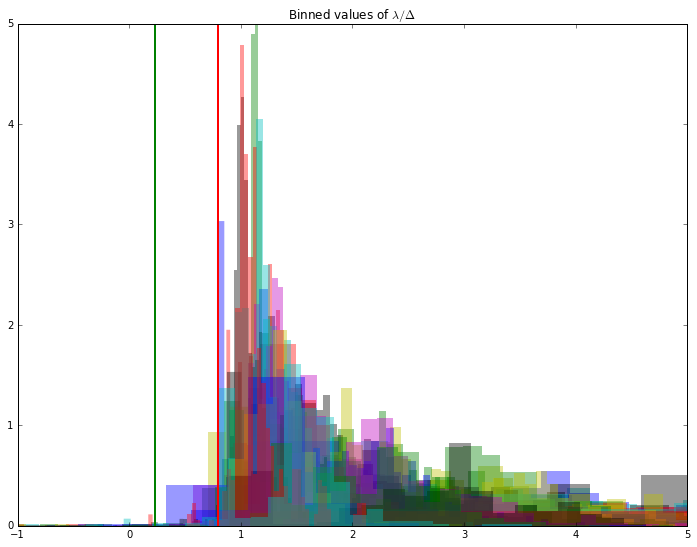

In [15]:
fig, ax = plt.subplots(figsize=(12, 9))

all_ratios = []

for click_model_type in MQD:
    for query in MQD[click_model_type]:
        relevances = MQD[click_model_type][query]['relevances']
        deltas = relevances[:, None] - relevances[None, :]
        lambdas = MQD[click_model_type][query]['stats'][1000000]['lambdas']
        
        y = lambdas.ravel()
        x = np.tile(deltas.ravel(), (lambdas.shape[0],))
        
        nnz_x_mask = (x != 0.)
        
        x = x[nnz_x_mask]
        y = y[nnz_x_mask]
        
        ratio = np.clip(y / x, a_min=0, a_max=10)
        
        all_ratios.append(ratio)
        
        ax.hist(ratio, 50, edgecolor='none', normed=True, alpha=0.4)

all_ratios = np.concatenate(all_ratios)
all_ratios.sort()

alpha = 0.0033
ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='g', lw=2)
print 'Green line is at',all_ratios[int(alpha * all_ratios.shape[0])]

alpha = 0.01
ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='r', lw=2)
print 'Red line is at',all_ratios[int(alpha * all_ratios.shape[0])]

ax.set_xlim([-1, 5])
ax.set_ylim([0, 5])
ax.set_title(r'Binned values of ${\lambda}/{\Delta}$')
plt.show(fig)

## Ignoring small $\Delta$ values (< 1e-3)

Green line is at 0.741911843196
Red line is at 0.804044404376


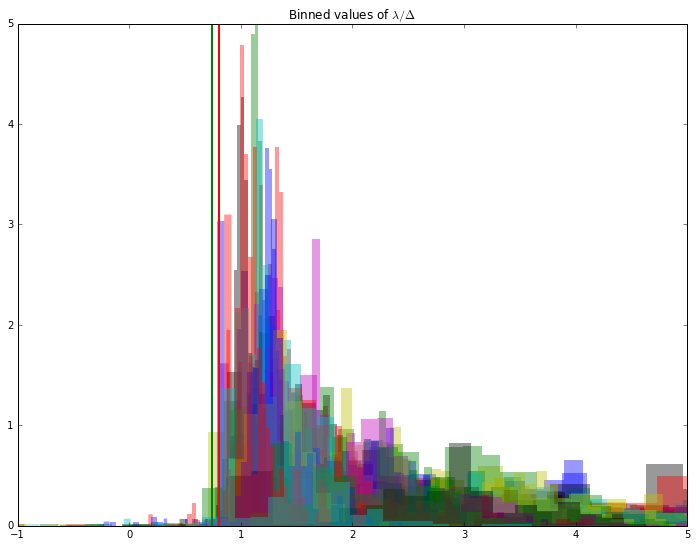

In [16]:
fig, ax = plt.subplots(figsize=(12, 9))

all_ratios = []

for click_model_type in MQD:
    for query in MQD[click_model_type]:
        relevances = MQD[click_model_type][query]['relevances']
        deltas = relevances[:, None] - relevances[None, :]
        lambdas = MQD[click_model_type][query]['stats'][1000000]['lambdas']
        
        y = lambdas.ravel()
        x = np.tile(deltas.ravel(), (lambdas.shape[0],))
        
        nts_x_mask = (np.abs(x) > 1e-3)
        
        x = x[nts_x_mask]
        y = y[nts_x_mask]
        
        ratio = np.clip(y / x, a_min=0, a_max=10)
        
        all_ratios.append(ratio)
        
        ax.hist(ratio, 50, edgecolor='none', normed=True, alpha=0.4)

all_ratios = np.concatenate(all_ratios)
all_ratios.sort()

alpha = 0.0033
ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='g', lw=2)
print 'Green line is at',all_ratios[int(alpha * all_ratios.shape[0])]

alpha = 0.01
ax.axvline(all_ratios[int(alpha * all_ratios.shape[0])], color='r', lw=2)
print 'Red line is at',all_ratios[int(alpha * all_ratios.shape[0])]

ax.set_xlim([-1, 5])
ax.set_ylim([0, 5])
ax.set_title(r'Binned values of ${\lambda}/{\Delta}$')
plt.show(fig)